# __Include marginal CO2 emissions into dataset__

In [36]:
import pandas as pd
import os
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# let's load our data together with some assertions

def mod_concat_NEMDE(file_path):
    '''
    load modified df of concatenated pkl chunks after clean_filter_concat_pkl func application
    '''
    df = pd.read_pickle(file_path)
    df.drop(columns=["BandNo","RRNBandPrice","BandCost"], inplace=True)
    df = df.set_index('PeriodID', drop=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df[["Price", "Increase"]] = df[["Price", "Increase"]].astype(float)
    df.rename(columns={"Unit":"DUID"}, inplace=True)
    df.sort_index(inplace=True, ascending=True)
    df.index = df.index - dt.timedelta(minutes = 5)
    df.rename(columns={"Unit":"DUID"}, inplace=True)
    
    assert df["Price"].dtype == float
    assert df["Increase"].dtype == float
    assert not df.isna().any().any()
    
    return df

In [41]:
file = '../../big_data/concat_for_energy_SA1.pkl'
df = mod_concat_NEMDE(file)

In [42]:
df.head()

,RegionID,Market,Price,DUID,DispatchedMarket,Increase
PeriodID,,,,,,
2009-07-01 04:00:00,SA1,Energy,1.35918,ER02,ENOF,-0.08861
2009-07-01 04:00:00,SA1,Energy,1.35918,ER03,ENOF,-0.08861
2009-07-01 04:00:00,SA1,Energy,1.35918,ER04,ENOF,-0.08861
2009-07-01 04:00:00,SA1,Energy,1.35918,"ENOF,YWPS2,2,YWPS3,2",tbslack1,185.75049
2009-07-01 04:00:00,SA1,Energy,1.35918,ER01,ENOF,-0.08861


## __Assign marginal CO2 emissions to each dispatch time point__

In our dataframe we have scraped and concatenated, there is a column called DUID. That column represents the ID of the energy generator which can be associated to its specific CO2 emissions. For that association, we use the DUID_CO2.csv file which links DUID with its specific emissions (CO2E_EMISSIONS_FACTOR).

In [43]:
path = '../data/DUID_CO2.csv'
CO2_generators = pd.read_csv(path)
print(CO2_generators.shape)
CO2_generators.head()

(428, 6)


,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
0,AGLNOW1,AGLNOW1,NSW1,0.062,Landfill biogas methane,NGA 2018
1,AGLSITA1,AGLSITA1,NSW1,0.062,Landfill biogas methane,NGA 2018
2,APPIN,APPIN,NSW1,0.765,Coal seam methane,NGA 2018
3,BDONGHYD,BDONGHYD,NSW1,0.000,Hydro,ISP 2018
4,BERYLSF1,BERYLSF1,NSW1,0.000,Solar,ISP 2018


DUID and GENSETID appear to be the same columns. But are they? Let's find out in the next couple of cells.

In [44]:
def DUID_items(NEMDE_market_df, CO2_generators_df):
    '''
    Input dataframes with the generator ID columns named "DUID" in each case
    A list variable is returned
    '''
    lst1 = []
    for i in set(NEMDE_market_df.DUID):
        if i in set(CO2_generators_df.DUID):
            lst1.append(i)
    print('The NEMDE_market_table uses {} DUID items from the DUID CO2_generator column.'.format(len(lst1)))
    
    lst2 = []
    for i in set(NEMDE_market_df.DUID):
        if i in set(CO2_generators_df.GENSETID):
            lst2.append(i)
    print('The NEMDE_market_table uses {} DUID items from the GENSETID CO2_generator column.'.format(len(lst2)))
    
    lst_diff =[]
    for i in lst2:
        if i not in lst1:
            lst_diff.append(i)
    print('The items {} from the GENSETID column should be added to the DUID column for it to maximise its NEMDE market_table representation.'.format(lst_diff))
    return lst_diff

In [45]:
lst_diff = DUID_items(df, CO2_generators)
lst_diff

The NEMDE_market_table uses 200 DUID items from the DUID CO2_generator column.
The NEMDE_market_table uses 186 DUID items from the GENSETID CO2_generator column.
The items ['ANGAS2', 'MCKAY2', 'ANGAS1'] from the GENSETID column should be added to the DUID column for it to maximise its NEMDE market_table representation.


['ANGAS2', 'MCKAY2', 'ANGAS1']

In [46]:
CO2_generators[(CO2_generators.GENSETID == 'MCKAY2') | (CO2_generators.GENSETID == 'ANGAS2') | (CO2_generators.GENSETID == 'ANGAS1')]

,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
219,ANGAST1,ANGAS1,SA1,1.0136,Diesel oil,ISP 2018
220,ANGAST1,ANGAS2,SA1,1.0136,Diesel oil,ISP 2018
381,MCKAY1,MCKAY2,VIC1,0.0000,Hydro,ISP 2018


### __Next, we see if the DUID column contains only unique DUIDs__

In [47]:
CO2_generators.DUID.nunique() #assert

384

From the above result, we can see that the DUID_CO2 table contains some DUIDs severel times (table size is 428, number of unique DUIDs is 384). Now the question becomes whether the specific CO2 emissions of redundant DUIDs are consistent among DUID repetitions. Let's find out in the following.

In [48]:
# Here, we get rid of redundant info by grouping by the DUID column, taking the mean of the CO2 emissions.

CO2_generators_grouped = CO2_generators.groupby("DUID").mean().reset_index()
CO2_generators_grouped.head()

,DUID,CO2E_EMISSIONS_FACTOR
0,AGLHAL,1.174440
1,AGLNOW1,0.062000
2,AGLSITA1,0.062000
3,AGLSOM,0.817915
4,ANGAST1,1.013600


In [49]:
# here, we get rid of redundant DUID info by simply dropping duplicates.

CO2_generators_unique = CO2_generators.drop_duplicates("DUID")
CO2_generators_unique = CO2_generators_unique.sort_values(by="DUID").reset_index(drop=True)
print(CO2_generators_unique.shape)
CO2_generators_unique.head()

(384, 6)


,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
0,AGLHAL,AGLHAL,SA1,1.174440,Natural Gas (Pipeline),ISP 2018
1,AGLNOW1,AGLNOW1,NSW1,0.062000,Landfill biogas methane,NGA 2018
2,AGLSITA1,AGLSITA1,NSW1,0.062000,Landfill biogas methane,NGA 2018
3,AGLSOM,AGLSOM,VIC1,0.817915,Natural Gas (Pipeline),ISP 2018
4,ANGAST1,ANGAS1,SA1,1.013600,Diesel oil,ISP 2018


With our two approaches to get rid of redundant DUID, we can now easily check whether redundant DUIDs were linking always the same DUID with the same CO2 emission. Let's see how in the following cells.

In [50]:
count = 0
lst_i = []
for i in CO2_generators_unique.CO2E_EMISSIONS_FACTOR.index:
    if abs(CO2_generators_unique.CO2E_EMISSIONS_FACTOR[i] - CO2_generators_grouped.CO2E_EMISSIONS_FACTOR[i]) > 0.001:
        lst_i.append(i)
        r = CO2_generators_unique.iloc[[i]]
r

,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
17,BBASEHOS,BBASEH_1,VIC1,0.601,Natural Gas (Pipeline),NGA 2018


In [51]:
CO2_generators_grouped.iloc[[17],:]

,DUID,CO2E_EMISSIONS_FACTOR
17,BBASEHOS,0.719667


One redundant DUID uses different CO2 for its DUID subunits; we concider groupby(DUID) and using the mean CO2 emissions as the safesr approach and continue with that.

### __Merge of GENSETID with DUID__

In [52]:
def merge_DUID_GENSETID(CO2_generators_df):
    '''
    This function takes care of the mismatch output by DUID_items. Note that .groupby("DUID").mean() is applied to the
    CO2_generators table. Hence, only numerical columns are returned.
    '''
    CO2_generators_grouped = CO2_generators.groupby("DUID").mean().reset_index()
    count = -1
    for i in CO2_generators.GENSETID:
        count += 1
        if i in lst_diff:
            CO2_generators_grouped = pd.concat([CO2_generators_grouped, CO2_generators.iloc[[count],:]\
                                                .loc[:,["GENSETID","CO2E_EMISSIONS_FACTOR"]].rename(columns={"GENSETID":"DUID"})],)
    CO2_generators_grouped = CO2_generators_grouped.sort_values(by="DUID").reset_index(drop=True)
    return CO2_generators_grouped

In [53]:
CO2_generators_complete = merge_DUID_GENSETID(CO2_generators)
print(CO2_generators_complete.shape)
CO2_generators_complete[(CO2_generators_complete.DUID == 'MCKAY2') | 
                        (CO2_generators_complete.DUID == 'ANGAS2') | 
                        (CO2_generators_complete.DUID == 'ANGAS1')]
CO2_generators_complete

(387, 2)


,DUID,CO2E_EMISSIONS_FACTOR
0,AGLHAL,1.174440
1,AGLNOW1,0.062000
2,AGLSITA1,0.062000
3,AGLSOM,0.817915
4,ANGAS1,1.013600
...,...,...
382,YWNL1,1.315515
383,YWPS1,1.315515
384,YWPS2,1.315515
385,YWPS3,1.315515


In [54]:
#file_path = '{}/nem-data/nemde_clean/all_DUIDs.pkl'.format(os.environ['HOME'])
#pd.to_pickle(CO2_generators_complete, file_path)

### __Merge our original dataframe with dispatch time points with preprocessed DUID table to create time series of marginal CO2__

In [55]:
df_DUID_CO2 = df.reset_index().merge(CO2_generators_complete, how="left", on="DUID").set_index("PeriodID")
df_DUID_CO2 = df_DUID_CO2.drop(columns=["RegionID", "Market", "DispatchedMarket", "Increase"])
print(df_DUID_CO2.shape)

(6482840, 3)


In [82]:
pd.set_option('display.max_rows', 500)
df_DUID_CO2.head(150)

,Price,DUID,CO2E_EMISSIONS_FACTOR
PeriodID,,,
2009-07-01 04:00:00,1.35918,ER02,0.910143
2009-07-01 04:00:00,1.35918,ER03,0.910143
2009-07-01 04:00:00,1.35918,ER04,0.910143
2009-07-01 04:00:00,1.35918,"ENOF,YWPS2,2,YWPS3,2",NaN
2009-07-01 04:00:00,1.35918,ER01,0.910143
2009-07-01 04:00:00,1.35918,YWPS2,1.315515
2009-07-01 04:05:00,-0.00006,"ENOF,LKBONNY2,4,NPS2,2",NaN
2009-07-01 04:05:00,-0.00006,LKBONNY2,0.000000
2009-07-01 04:10:00,-0.00006,"ENOF,LKBONNY2,4,NPS2,2",NaN


In [57]:
df_DUID_CO2.isnull().any()

Price                    False
DUID                     False
CO2E_EMISSIONS_FACTOR     True
dtype: bool

Why have we got NaN values in the DUID column now? Remeber that per dispatch time point, there is a redundancy. It appears that not all DUIDs in our scraped dataframe refer to CO2 emissions, but only a subset. Hence, for those DUIDs which do not refer to any CO2 emissions not contained in our original DUID_CO2.csv leave behind a NaN value. 

<Figure size 864x360 with 0 Axes>

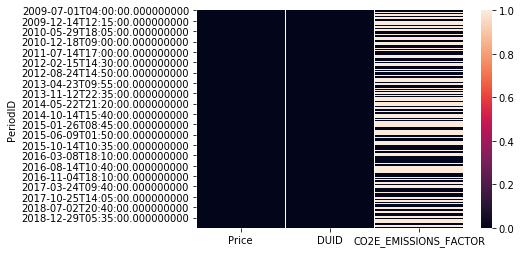

<Figure size 864x360 with 0 Axes>

In [58]:
fig = sns.heatmap(df_DUID_CO2.isnull())
plt.figure(figsize=(12,5))

### __Deducing the average marginal CO2 emissions per time point__

Notice that per point of time, several different energy production units may become dispatched. Hence, in the following we group our dataframe by the point of time and calculate the mean CO2 emission per point of time.

In [83]:
# note that in notebook 4, it was shown that taking the minimum of a grouped price causes minimal error
df_DUID_CO2_mean = df_DUID_CO2.groupby(df_DUID_CO2.index).agg({"Price":"min", "CO2E_EMISSIONS_FACTOR":"mean"}).sort_index(ascending=True)
print(df_DUID_CO2_mean.shape)
df_DUID_CO2_mean.head(30)

(1043372, 2)


,Price,CO2E_EMISSIONS_FACTOR
PeriodID,,
2009-07-01 04:00:00,1.35918,0.991217
2009-07-01 04:05:00,-0.00006,0.000000
2009-07-01 04:10:00,-0.00006,0.000000
2009-07-01 04:15:00,1.44014,0.991217
2009-07-01 04:20:00,1.75480,1.025701
2009-07-01 04:25:00,7.61813,0.910143
2009-07-01 04:30:00,7.64337,0.910143
2009-07-01 04:35:00,8.58237,0.910143
2009-07-01 04:40:00,8.00976,0.910143


<Figure size 864x360 with 0 Axes>

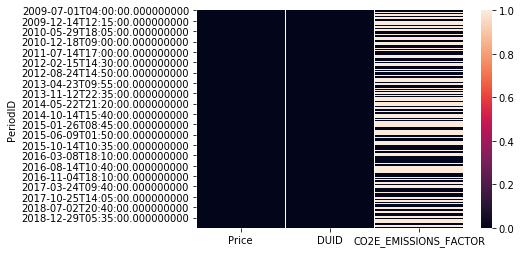

<Figure size 864x360 with 0 Axes>

In [84]:
fig = sns.heatmap(df_DUID_CO2.isnull())
plt.figure(figsize=(12,5))

In [85]:
df_DUID_CO2_mean.isna().any()

Price                    False
CO2E_EMISSIONS_FACTOR     True
dtype: bool

Despite our groupby action, the table still contains NaN values. These are from time points, where no matches were found between DUIDs and CO2 emissions although redundancy existed. We will take care of these values in the next notebook to perform proper data imputation.

### __Checking price range__

In the previous notebook, we found that some of the price values lie outside the range of what is allowed by the Australian energy market. Now that we have compressed our dataframe, we will enforce that limit onto our price column.

In [86]:
print(df_DUID_CO2_mean.Price.min())
print(df_DUID_CO2_mean.Price.max())

-26801.01057
2175000.0


In [87]:
print(sum(df_DUID_CO2_mean.Price >= 13500))
print(sum(df_DUID_CO2_mean.Price <= -1000))

231
68


In [88]:
def keep_price_range(df, price_min, price_max):
    '''
    To keep the price column within the possible price range
    df=dataframe with col="Price" filled with floats
    price_min=float or integer
    price_max=float or integer
    '''
    for i in range(df.shape[0]):
        if df.Price[i] > price_max:
            df.Price[i] = price_max
        elif df.Price[i] < price_min:
            df.Price[i] = price_min
        else:
            continue
    return df

In [89]:
df_DUID_CO2_mean = keep_price_range(df_DUID_CO2_mean, -1000, 13500)

In [90]:
print(df_DUID_CO2_mean.Price.min())
print(df_DUID_CO2_mean.Price.max())

-1000.0
13500.0


In [91]:
file_path = '../../big_data/df_DUID_price_range.pkl'
pd.to_pickle(df_DUID_CO2_mean, file_path)

### __Have we got what we think we have got?__

According to the source of our data of CO2 emissions, they were to be dispatched every 5 mins. However, can we really be sure that that's the case over a period of about 10 years? We will find that out over the next couple of cells.

In [206]:
def correct_timedelta(df, time_diff):
    '''
    df.index must be DateTimeIndex
    Returns two lists
    df=table_of_interest
    col="column_of_interest"
    time_diff=time_diff in seconds as int
    '''
    lst = []
    lst_i = []
    
    for i in range(1,df.shape[0]):
        delta = abs(df.index[i] - df.index[i-1])
        if int(delta.total_seconds()) != int(time_diff):
            lst.append(("from index {} on, it has been {} s or {} h.".format(i,int(delta.total_seconds()),(int(delta.total_seconds()/3600)))))
            lst_i.append((df.index[i],int(delta.total_seconds())))
            
    return lst, lst_i

In [207]:
lst, lst_i = correct_timedelta(df_DUID_CO2_mean, 300)

In [208]:
lst_i[:5]

[(Timestamp('2018-11-01 03:55:00'), 2592300),
 (Timestamp('2018-09-14 10:50:00'), 600),
 (Timestamp('2018-08-18 13:40:00'), 600),
 (Timestamp('2018-08-18 11:45:00'), 600),
 (Timestamp('2018-06-01 03:55:00'), 2592300),
 (Timestamp('2018-04-10 13:20:00'), 600),
 (Timestamp('2018-03-24 03:50:00'), 600),
 (Timestamp('2017-10-11 22:50:00'), 600),
 (Timestamp('2017-10-07 21:50:00'), 600),
 (Timestamp('2016-11-07 15:25:00'), 600),
 (Timestamp('2016-10-15 14:25:00'), 600),
 (Timestamp('2016-10-15 13:20:00'), 600),
 (Timestamp('2016-10-15 11:45:00'), 600),
 (Timestamp('2016-10-15 11:25:00'), 600),
 (Timestamp('2016-10-15 10:50:00'), 600),
 (Timestamp('2016-10-15 09:45:00'), 600),
 (Timestamp('2016-10-15 09:15:00'), 1200),
 (Timestamp('2016-10-15 07:35:00'), 600),
 (Timestamp('2016-09-09 03:10:00'), 600),
 (Timestamp('2016-09-09 02:45:00'), 600)]

## __Filling in the gaps__

### __DateTimeIndex__

Next, we will fill in the gaps of the DateTimeIndex. Note, that will leave us with NaN values in the remaining columns whereever datetimes are inserted into the index.

In [114]:
#hypothetical number of 5min intervals given the max and min values of the df time range

h = pd.date_range(start=df_DUID_CO2_mean.index.min(), end=df_DUID_CO2_mean.index.max(), freq="5min")
len(h)

1060704

In [155]:
assert abs(df_DUID_CO2_mean.shape[0] - len(h) + t) < 0.000001

In [199]:
df_full_time_mean = df_DUID_CO2_mean.reindex(h).sort_index(ascending=False)
print(df_full_time_mean.shape)
df_full_time_mean.head()

(1060704, 2)


,Price,CO2E_EMISSIONS_FACTOR
2019-08-01 03:55:00,79.52391,0.380340
2019-08-01 03:50:00,79.17710,0.456409
2019-08-01 03:45:00,85.14416,0.573436
2019-08-01 03:40:00,84.78689,0.573436
2019-08-01 03:35:00,84.78346,0.573436


In [170]:
df_full_time_mean.sort_index(ascending=False)
df_full_time_mean.isna().any()

Price                    True
CO2E_EMISSIONS_FACTOR    True
dtype: bool

### __Imputation of CO2 and price__

Due to the nature of time series data, the imputation of missing values needs extra attention. The potential presence of time series trends and seasonality renders imputations using e.g. mean or median deduced from the entire dataset little useful. Instead, any imputation should rather consider the local value range around a NaN value. In the following, we will see one approach of how that works.

<img src="../images/time_series_imputation.jpg"> <br/>
source: https://www.hindawi.com/journals/mpe/2010/513810/fig9/

In [171]:
file_path = '{}/nem-data/nemde_clean/df_DUID_CO2_mean.pkl'.format(os.environ['HOME'])
pd.to_pickle(df_full_time_mean, file_path)

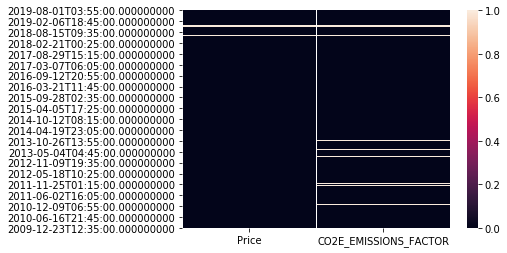

<Figure size 864x360 with 0 Axes>

In [178]:
fig = sns.heatmap(df_full_time_mean.isnull())
plt.figure(figsize=(12,5));

### __Deducing the sum of marginal CO2 emissions for each indivduaö time point__

Is it really best to take the mean of grouped CO2 emission values to plot them out or should we not take the sum? We prepare it here and see what's better in the next notebook.

In [174]:
df_DUID_CO2_sum = df_DUID_CO2.groupby(df_DUID_CO2.index).agg({"Price":"min", "CO2E_EMISSIONS_FACTOR":"sum"}).sort_index(ascending=False)
df_DUID_CO2_sum.head()

,Price,CO2E_EMISSIONS_FACTOR
PeriodID,,
2019-08-01 03:55:00,79.52391,1.141021
2019-08-01 03:50:00,79.17710,2.282043
2019-08-01 03:45:00,85.14416,0.573436
2019-08-01 03:40:00,84.78689,0.573436
2019-08-01 03:35:00,84.78346,0.573436


In [175]:
df_DUID_CO2_sum = keep_price_range(df_DUID_CO2_sum, -1000, 13500)

In [176]:
print(df_DUID_CO2_sum.Price.max())
print(df_DUID_CO2_sum.Price.min())

13500.0
-1000.0


In [209]:
lst1, lst_i1 = correct_timedelta(df_DUID_CO2_mean, 300)

In [210]:
lst[:5]

['from index 69984 on, it has been 2592300 s or 720 h.',
 'from index 83724 on, it has been 600 s or 0 h.',
 'from index 91465 on, it has been 600 s or 0 h.',
 'from index 91487 on, it has been 600 s or 0 h.',
 'from index 105405 on, it has been 2592300 s or 720 h.']

In [211]:
t = missing_intervals(lst_i1)
t

The number of missing 5min intervals is: 17332.


17332.0

In [212]:
#hypothetical number of 5min intervals given the max and min values of the df time range
h = pd.date_range(start=df_DUID_CO2_sum.index.min(), end=df_DUID_CO2_sum.index.max(), freq="5min")
len(h)

1060704

In [214]:
assert abs(df_DUID_CO2_sum.shape[0] - len(h) + t) < 0.000001

In [215]:
df_full_time_sum = df_DUID_CO2_sum.reindex(h).sort_index(ascending=False)
print(df_full_time_sum.shape)
df_full_time_sum.head()

(1060704, 2)


,Price,CO2E_EMISSIONS_FACTOR
2019-08-01 03:55:00,79.52391,1.141021
2019-08-01 03:50:00,79.17710,2.282043
2019-08-01 03:45:00,85.14416,0.573436
2019-08-01 03:40:00,84.78689,0.573436
2019-08-01 03:35:00,84.78346,0.573436


In [216]:
print(df_DUID_CO2_mean.index.min())
print(df_DUID_CO2_mean.index.max())

print(df_full_time_mean.index.min())
print(df_full_time_mean.index.max())

2009-07-01 04:00:00
2019-08-01 03:55:00
2009-07-01 04:00:00
2019-08-01 03:55:00


In [217]:
file_path = '{}/nem-data/nemde_clean/df_DUID_CO2_sum.pkl'.format(os.environ['HOME'])
pd.to_pickle(df_full_time_sum, file_path)